<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/models/base_models_STHyMOUNTAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Entrenamiento de Modelos Baseline para Predicción Espaciotemporal de Precipitación Mensual STHyMOUNTAIN

Este notebook implementa modelos baseline para la predicción de precipitaciones usando datos espaciotemporales.

## 🔍 Implementación de Modelos Avanzados y Técnicas de Validación

Además de los modelos tabulares baseline, implementaremos:

1. **Optimización avanzada con Optuna** para los modelos tabulares XGBoost y LightGBM
2. **Validación robusta** mediante:
   - Hold-Out Validation (ya implementada)
   - Cross-Validation (k=5)
   - Bootstrapping (100 muestras)
3. **Modelos de Deep Learning** para capturar patrones espaciales y temporales:
   - Redes CNN para patrones espaciales
   - Redes ConvLSTM para patrones espaciotemporales

El objetivo es proporcionar una evaluación completa de diferentes enfoques de modelado para la predicción de precipitación en regiones montañosas.

In [ ]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil
import time
import psutil

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio para salida de modelos creado: {model_output_dir}")

# Implementación de resiliencia para interacción con Google Drive y restauración de datos
def backup_dataframe(df, backup_path):
    """Guarda un DataFrame como respaldo en formato Parquet."""
    try:
        df.to_parquet(backup_path, index=False)
        print(f"Respaldo del DataFrame guardado en: {backup_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del DataFrame: {e}")

def restore_dataframe(backup_path):
    """Restaura un DataFrame desde un archivo de respaldo en formato Parquet."""
    try:
        if backup_path.exists():
            df_restored = pd.read_parquet(backup_path)
            print(f"DataFrame restaurado desde: {backup_path}")
            return df_restored
        else:
            print(f"No se encontró el archivo de respaldo en: {backup_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el DataFrame: {e}")
        return None

# Ruta para respaldo temporal del DataFrame
temp_dir = BASE_PATH / 'data' / 'output' / 'temp'
temp_dir.mkdir(parents=True, exist_ok=True)
temp_file_path = temp_dir / 'dataframe_backup.parquet'

# Respaldo inicial del DataFrame principal
if 'df' in locals() and df is not None:
    backup_dataframe(df, temp_file_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local.")
        df = restore_dataframe(temp_file_path)

# Restaurar modelos guardados en caso de fallo
model_files = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost': model_output_dir / 'XGBoost.pkl',
    'LightGBM': model_output_dir / 'LightGBM.pkl'
}

def load_saved_model(model_name, model_path):
    """Carga un modelo guardado desde disco."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
            print(f"Modelo {model_name} cargado desde: {model_path}")
            return model
    except Exception as e:
        print(f"Error al cargar el modelo {model_name}: {e}")
        return None

# Inicializar `modelos_base` como un diccionario vacío
modelos_base = {}

# Intentar cargar modelos guardados
for model_name, model_path in model_files.items():
    if model_name not in modelos_base:
        modelos_base[model_name] = load_saved_model(model_name, model_path)

# Implementación de resiliencia para modelos CNN y ConvLSTM

# Respaldo y restauración de modelos CNN y ConvLSTM
cnn_model_path = model_output_dir / 'cnn_model.h5'
convlstm_model_path = model_output_dir / 'convlstm_model.h5'

def backup_model(model, model_path):
    """Guarda un modelo de Keras como respaldo."""
    try:
        model.save(model_path)
        print(f"Modelo respaldado en: {model_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del modelo: {e}")

def restore_model(model_path):
    """Restaura un modelo de Keras desde un archivo de respaldo."""
    try:
        if model_path.exists():
            model = tf.keras.models.load_model(model_path)
            print(f"Modelo restaurado desde: {model_path}")
            return model
        else:
            print(f"No se encontró el archivo de respaldo en: {model_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el modelo: {e}")
        return None

# Respaldo inicial de modelos si existen
if 'cnn_model' in locals() and cnn_model is not None:
    backup_model(cnn_model, cnn_model_path)
if 'convlstm_model' in locals() and convlstm_model is not None:
    backup_model(convlstm_model, convlstm_model_path)

# Restaurar modelos en caso de fallo
if 'cnn_model' not in locals() or cnn_model is None:
    cnn_model = restore_model(cnn_model_path)
if 'convlstm_model' not in locals() or convlstm_model is None:
    convlstm_model = restore_model(convlstm_model_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local para modelos CNN y ConvLSTM.")

Entorno configurado. Usando ruta base: ..
Directorio para salida de modelos creado: ../models/output
Error al cargar el modelo RandomForest: name 'pickle' is not defined
Error al cargar el modelo XGBoost: name 'pickle' is not defined
Error al cargar el modelo LightGBM: name 'pickle' is not defined
No se encontró el archivo de respaldo en: ../models/output/cnn_model.h5
No se encontró el archivo de respaldo en: ../models/output/convlstm_model.h5


In [2]:
# 1. Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import optuna
import pickle
import datetime
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones para barras de progreso y mejora de visualización
from tqdm.notebook import tqdm, trange
from IPython.display import display, HTML, clear_output
import time

# Configurar visualización más atractiva
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
# Importaciones adicionales para Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, 
                                   MaxPooling2D, Flatten, Input, concatenate, Reshape, TimeDistributed, UpSampling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("TensorFlow versión:", tf.__version__)

# Configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU disponible: {physical_devices}")
    # Permitir crecimiento de memoria según sea necesario
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectó GPU. Usando CPU.")

TensorFlow versión: 2.18.0
No se detectó GPU. Usando CPU.


In [4]:
# 2. Cargar el dataset NetCDF
def load_dataset(file_path):
    """Carga un archivo NetCDF y lo convierte a pandas DataFrame"""
    try:
        # Cargar el archivo NetCDF con xarray
        print(f"Intentando cargar el archivo: {file_path}")
        ds = xr.open_dataset(file_path)
        print("Archivo cargado exitosamente con xarray")

        # Mostrar información del dataset cargado
        print("\nInformación del dataset:")
        print(ds.info())
        print("\nVariables disponibles:")
        for var_name in ds.data_vars:
            print(f"- {var_name}: {ds[var_name].shape}")

        # Convertir a DataFrame
        df = ds.to_dataframe().reset_index()
        return df, ds
    except Exception as e:
        print(f"Error al cargar el archivo NetCDF: {e}")
        return None, None

# Ruta al dataset
data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
print(f"Buscando archivo en: {data_file}")

# Cargar el dataset
df, ds_original = load_dataset(data_file)

# Verificar si se cargó correctamente
if df is not None:
    print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
    print("\nPrimeras filas del DataFrame:")
    display(df.head())
else:
    print("No se pudo cargar el dataset. Verificar la ruta y el formato del archivo.")

Buscando archivo en: ../data/output/complete_dataset_with_features.nc
Intentando cargar el archivo: ../data/output/complete_dataset_with_features.nc
Archivo cargado exitosamente con xarray

Información del dataset:
xarray.Dataset {
dimensions:
	time = 530 ;
	latitude = 62 ;
	longitude = 66 ;

variables:
	datetime64[ns] time(time) ;
	float32 latitude(latitude) ;
	float32 longitude(longitude) ;
	float32 total_precipitation(time, latitude, longitude) ;
	float32 max_daily_precipitation(time, latitude, longitude) ;
	float32 min_daily_precipitation(time, latitude, longitude) ;
	float32 daily_precipitation_std(time, latitude, longitude) ;
	float32 month_sin(time, latitude, longitude) ;
	float32 month_cos(time, latitude, longitude) ;
	float32 doy_sin(time, latitude, longitude) ;
	float32 doy_cos(time, latitude, longitude) ;
	float64 elevation(latitude, longitude) ;
	float32 slope(latitude, longitude) ;
	float32 aspect(latitude, longitude) ;

// global attributes:
	:description = ST-HyMOUNTAIN-

,time,latitude,longitude,total_precipitation,max_daily_precipitation,min_daily_precipitation,daily_precipitation_std,month_sin,month_cos,doy_sin,doy_cos,elevation,slope,aspect
0,1981-01-01,4.324997,-74.975006,47.381050,24.706928,0.0,5.825776,0.5,0.866025,0.017202,0.999852,493.784552,89.539551,102.044502
1,1981-01-01,4.324997,-74.925003,40.750824,21.819195,0.0,5.019045,0.5,0.866025,0.017202,0.999852,519.750107,89.867020,73.481674
2,1981-01-01,4.324997,-74.875008,46.338623,26.092327,0.0,5.740223,0.5,0.866025,0.017202,0.999852,248.776045,89.722221,65.916817
3,1981-01-01,4.324997,-74.825005,48.779938,29.421450,0.0,5.611738,0.5,0.866025,0.017202,0.999852,351.415728,86.986130,140.916000
4,1981-01-01,4.324997,-74.775002,38.932945,18.483061,0.0,3.733574,0.5,0.866025,0.017202,0.999852,278.261922,88.273293,18.439939


In [5]:
# 3. Preparación de los datos
if df is not None:
    # Identificar la columna objetivo (precipitación)
    target_column = 'total_precipitation'  # Ajustar si tiene otro nombre en tu dataset

    # Ver si existe 'precip_target' o usar 'total_precipitation'
    if 'total_precipitation' in df.columns:
        target_column = 'total_precipitation'

    print(f"Columna objetivo identificada: {target_column}")

    # Separar variables predictoras y variable objetivo
    feature_cols = [col for col in df.columns if col != target_column and not pd.isna(df[col]).all()]

    # Eliminar columnas no numéricas para los modelos (como fechas o coordenadas si no se usan como features)
    non_feature_cols = ['time', 'spatial_ref']
    feature_cols = [col for col in feature_cols if col not in non_feature_cols]

    # Eliminar filas con valores NaN
    print(f"Filas antes de eliminar NaN: {df.shape[0]}")
    df_clean = df.dropna(subset=[target_column] + feature_cols)
    print(f"Filas después de eliminar NaN: {df_clean.shape[0]}")

    # Separar features y target
    X = df_clean[feature_cols]
    y = df_clean[target_column]

    print(f"\nFeatures seleccionadas ({len(feature_cols)}):\n{feature_cols}")
    print(f"\nVariable objetivo: {target_column}")

Columna objetivo identificada: total_precipitation
Filas antes de eliminar NaN: 2168760
Filas después de eliminar NaN: 2168760

Features seleccionadas (12):
['latitude', 'longitude', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']

Variable objetivo: total_precipitation


In [6]:
# 4. División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

# 5. Estandarización de variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler para uso futuro
with open(model_output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Escalador guardado en models/output/scaler.pkl")

Dimensiones del conjunto de entrenamiento: (1735008, 12)
Dimensiones del conjunto de prueba: (433752, 12)
Escalador guardado en models/output/scaler.pkl


In [7]:
# 6. Funciones de evaluación y entrenamiento
def evaluar_modelo(y_true, y_pred):
    """Evalúa el rendimiento de un modelo usando múltiples métricas"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def entrenar_y_evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test):
    """Entrena un modelo y evalúa su rendimiento con visualización del progreso"""
    # Crear widget para mostrar información del proceso
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                 f'<div id="status_{nombre}">Estado: Iniciando entrenamiento...</div>' +
                 f'</div>'))
    
    # Tiempo de inicio
    start_time = time.time()
    
    # Entrenar el modelo con seguimiento visual según el tipo
    if hasattr(modelo, 'fit_generator') or nombre in ['XGBoost', 'XGBoost_Optuna', 'LightGBM', 'LightGBM_Optuna']:
        # Para modelos que soportan entrenamiento por lotes como XGBoost, LightGBM
        print(f"Entrenando {nombre} con visualización de progreso...")
        if hasattr(modelo, 'n_estimators'):
            n_estimators = modelo.n_estimators
            for i in tqdm(range(n_estimators), desc=f"Entrenando {nombre}"):
                if i == 0:
                    # Primera iteración, ajuste inicial
                    if nombre.startswith('LightGBM'):
                        # LightGBM tiene parámetro verbose
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                 if k != 'n_estimators' and k != 'verbose'}, verbose=-1)
                    else:
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                if k != 'n_estimators'})
                    temp_modelo.fit(X_train, y_train)
                elif i == n_estimators - 1:
                    # Última iteración, ajuste completo
                    modelo.fit(X_train, y_train)
                
                # Actualizar progreso visual
                if i % max(1, n_estimators // 10) == 0:
                    clear_output(wait=True)
                    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                                f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                                f'<div id="status_{nombre}">Estado: Progreso {i+1}/{n_estimators} estimadores ({((i+1)/n_estimators*100):.1f}%)</div>' +
                                f'</div>'))
                    time.sleep(0.1)  # Pequeña pausa para actualización visual
        else:
            # Si no tiene n_estimators, entrenamiento directo
            modelo.fit(X_train, y_train)
    else:
        # Para modelos estándar como RandomForest
        modelo.fit(X_train, y_train)
    
    # Tiempo de entrenamiento
    training_time = time.time() - start_time
    
    # Visualizar tiempo de entrenamiento
    display(HTML(f'<div style="background-color:#e6ffe6; padding:10px; border-radius:5px;">' +
                f'<h3>✅ Entrenamiento completado: {nombre}</h3>' +
                f'<div>Tiempo de entrenamiento: {training_time:.2f} segundos</div>' +
                f'</div>'))
    
    print(f"Evaluando rendimiento de {nombre}...")
    predicciones = modelo.predict(X_test)
    rmse, mae, r2 = evaluar_modelo(y_test, predicciones)
    
    # Visualizar métricas con estilo
    display(HTML(f'<div style="background-color:#f5f5dc; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>📊 Métricas para {nombre}</h3>' +
                f'<table style="width:100%; text-align:left;">' +
                f'<tr><th>Métrica</th><th>Valor</th></tr>' +
                f'<tr><td>RMSE</td><td>{rmse:.4f}</td></tr>' +
                f'<tr><td>MAE</td><td>{mae:.4f}</td></tr>' +
                f'<tr><td>R²</td><td>{r2:.4f}</td></tr>' +
                f'</table></div>'))
    
    return modelo, (rmse, mae, r2)

def guardar_modelo(modelo, nombre):
    """Guarda un modelo entrenado en disco"""
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # filename = f"{nombre}_{timestamp}.pkl"
    filename = f"{nombre}.pkl"
    with open(model_output_dir / filename, 'wb') as f:
        pickle.dump(modelo, f)
    
    # Visualizar confirmación de guardado
    display(HTML(f'<div style="background-color:#e6ffee; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>💾 Modelo guardado</h3>' +
                f'<div>Modelo <b>{nombre}</b> guardado como: {filename}</div>' +
                f'</div>'))
    return filename

Modelo RandomForest encontrado en ../models/output/RandomForest.pkl. Cargando...
Evaluando modelo RandomForest...
✅ RandomForest evaluado: RMSE=36.4174, MAE=24.8917, R2=0.9168
Modelo XGBoost encontrado en ../models/output/XGBoost.pkl. Cargando...
Evaluando modelo XGBoost...
✅ XGBoost evaluado: RMSE=37.8542, MAE=26.3499, R2=0.9101
Modelo LightGBM encontrado en ../models/output/LightGBM.pkl. Cargando...
Evaluando modelo LightGBM...


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LightGBM evaluado: RMSE=39.0589, MAE=27.3338, R2=0.9043

🔍 Comparación de modelos base sin optimización:

Ordenados por RMSE (menor es mejor):


,RMSE,MAE,R2
RandomForest,36.417363,24.891715,0.916798
XGBoost,37.854203,26.349937,0.910103
LightGBM,39.058929,27.333847,0.904290


/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_52421/2738636059.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp_df.index, y=temp_df['RMSE'], palette='coolwarm')


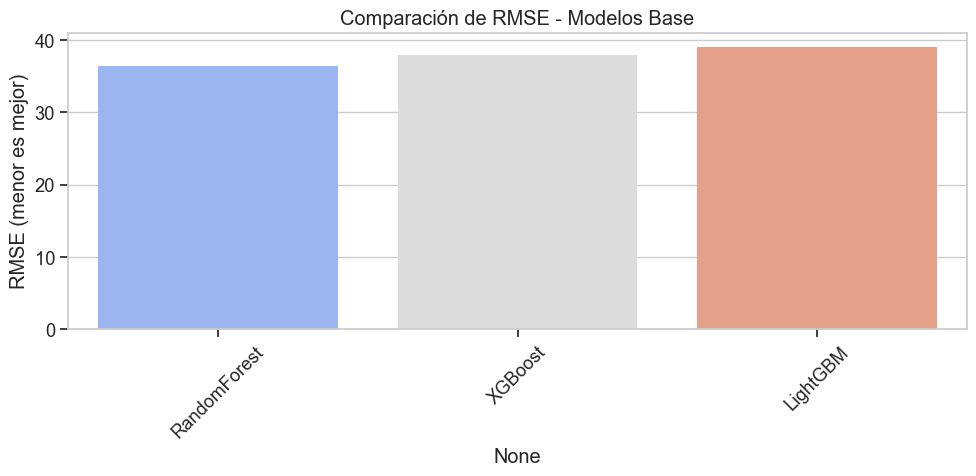

In [ ]:
# 🔁 1. Importaciones necesarias
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from pathlib import Path

# ⚙️ 2. Diccionarios de almacenamiento
resultados_base = {}
modelos_base = {}
modelos_guardados = {}

# 📁 3. Rutas de modelos guardados

model_paths = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost': model_output_dir / 'XGBoost.pkl',
    'LightGBM': model_output_dir / 'LightGBM.pkl'
}

# ✅ 4. Carga y evaluación de modelos estándar o entrenamiento si no existen
for model_name, model_path in model_paths.items():
    if model_name in ['RandomForest', 'XGBoost', 'LightGBM']:
        if model_path.exists():
            print(f"Modelo {model_name} encontrado en {model_path}. Cargando...")
            with open(model_path, 'rb') as f:
                modelo = pickle.load(f)
                modelos_base[model_name] = modelo
        else:
            print(f"Modelo {model_name} no encontrado. Entrenando desde cero...")
            if model_name == 'RandomForest':
                modelo = RandomForestRegressor(n_estimators=100, random_state=42)
            elif model_name == 'XGBoost':
                modelo = XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='rmse')
            elif model_name == 'LightGBM':
                modelo = LGBMRegressor(n_estimators=100, random_state=42)
            
            # Entrenar el modelo
            modelo.fit(X_train_scaled, y_train)
            modelos_base[model_name] = modelo
            
            # Guardar el modelo entrenado
            with open(model_path, 'wb') as f:
                pickle.dump(modelo, f)
            print(f"Modelo {model_name} entrenado y guardado en {model_path}.")
        
        # Evaluar el modelo
        print(f"Evaluando modelo {model_name}...")
        if 'LightGBM' in model_name:
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)
        y_pred = modelo.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        resultados_base[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
        print(f"✅ {model_name} evaluado: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

# 📊 5. Visualización de resultados
print("\n🔍 Comparación de modelos base sin optimización:")
temp_df = pd.DataFrame(resultados_base, index=['RMSE', 'MAE', 'R2']).T

# Mostrar tabla ordenada por RMSE
print("\nOrdenados por RMSE (menor es mejor):")
display(temp_df.sort_values('RMSE'))

# Gráfico de comparación de RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x=temp_df.index, y=temp_df['RMSE'], palette='coolwarm')
plt.title('Comparación de RMSE - Modelos Base')
plt.ylabel('RMSE (menor es mejor)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model_output_dir / 'baseline_rmse_comparison_full.png')
plt.show()


In [ ]:
# ✅ Versión robusta optimizada con control de memoria para Colab y local

import os
import gc
import psutil
import warnings
import pickle
import optuna
import numpy as np
from pathlib import Path
from sqlalchemy.exc import OperationalError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display, HTML

def display_training_status(model_name, status):
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {model_name}</h3>' +
                 f'<div>Estado: {status}</div>' +
                 f'</div>'))

def handle_training_error(model_name, error):
    display(HTML(f'<div style="background-color:#ffe6e6; padding:10px; border-radius:5px;">' +
                 f'<h3>❌ Error en modelo: {model_name}</h3>' +
                 f'<div>Error: {error}</div>' +
                 f'</div>'))

resultados_base = {}
model_paths = {}

def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def check_memory(threshold_gb=0.5):
    available = psutil.virtual_memory().available / (1024 ** 3)
    if available < threshold_gb:
        raise MemoryError(f"🚫 Memoria RAM insuficiente (< {threshold_gb:.2f} GB disponibles)")

def get_optuna_storage_path(model_type):
    if is_running_in_colab():
        print("💡 Ejecutando en Google Colab: usando SQLite en memoria RAM")
        return "sqlite:///:memory:"
    else:
        db_path = validate_database_path(model_output_dir / f"{model_type}_study.db")
        return f"sqlite:///{db_path}"

def suppress_specific_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
    os.environ["XGBOOST_DISABLE_USE_LABEL_ENCODER"] = "1"

suppress_specific_warnings()

def validate_database_path(db_path):
    try:
        with open(db_path, 'a') as f:
            pass
        print(f"✅ Base de datos validada: {db_path}")
    except IOError as e:
        print(f"❌ Error en base de datos: {e}. Usando memoria temporal.")
        return ':memory:'
    return db_path

class OptimizationProgressCallback:
    def __init__(self, total_trials, model_name="Modelo"):
        self.total_trials = total_trials
        self.model_name = model_name
    def __call__(self, study, trial):
        completed_trials = len(study.trials)
        if completed_trials % 5 == 0 or completed_trials == self.total_trials:
            print(f"📈 [{self.model_name}] Trials completados: {completed_trials}/{self.total_trials}")

def run_memory_efficient_optimization(model_type, X_train, y_train, X_test, y_test):
    print(f"\n📊 Iniciando optimización adaptativa para {model_type}...")
    gc.collect()
    model_path = model_output_dir / f"{model_type}_optimized.pkl"
    if model_path.exists():
        print(f"✅ Modelo optimizado encontrado: {model_path}. Cargando...")
        with open(model_path, 'rb') as f:
            best_model = pickle.load(f)
        y_pred = best_model.predict(X_test)
        return None, best_model, (
            np.sqrt(mean_squared_error(y_test, y_pred)),
            mean_absolute_error(y_test, y_pred),
            r2_score(y_test, y_pred)
        )

    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    print(f"Memoria RAM disponible: {available_memory_gb:.2f} GB")

    model_types = {
        'RandomForest': RandomForestRegressor,
        'XGBoost': XGBRegressor,
        'LightGBM': LGBMRegressor
    }
    if model_type not in model_types:
        raise ValueError(f"Tipo de modelo no soportado: {model_type}.")

    if available_memory_gb < 2.0:
        n_trials, max_estimators, max_depth, subsample = 10, 50, 6, 0.5
    elif available_memory_gb < 8.0:
        n_trials, max_estimators, max_depth, subsample = 20, 200, 12, 0.7
    else:
        n_trials, max_estimators, max_depth, subsample = 30, 300, 20, 0.9

    def objective(trial):
        common_params = {'random_state': 42}

        if len(X_train) > 20000:
            idx = np.random.choice(np.arange(len(X_train)), size=int(0.3 * len(X_train)), replace=False)
            X_sub, y_sub = X_train[idx], y_train[idx]
        else:
            X_sub, y_sub = X_train, y_train

        if model_type == 'RandomForest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'n_jobs': 1
            }
        elif model_type == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, subsample),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'tree_method': 'hist',
                'n_jobs': 1,
                'verbosity': 0
            }
        elif model_type == 'LightGBM':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, max_estimators),
                'max_depth': trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, subsample),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
                'boosting_type': 'gbdt',
                'n_jobs': 1,
                'verbose': -1
            }
        params.update(common_params)
        gc.collect()

        try:
            check_memory(0.5)
            model = model_types[model_type](**params)
            model.fit(X_sub, y_sub)
            y_pred = model.predict(X_test)
            score = np.sqrt(mean_squared_error(y_test, y_pred))
        except Exception as e:
            print(f"⚠️ Error: {e}")
            score = float('inf')
        finally:
            del model, y_pred, X_sub, y_sub
            gc.collect()
        return score

    storage_path = get_optuna_storage_path(model_type)
    try:
        study = optuna.create_study(
            study_name=f"{model_type}_memory_optimized",
            storage=storage_path,
            direction='minimize',
            sampler=optuna.samplers.TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=3),
            load_if_exists=not is_running_in_colab()
        )
        study.optimize(objective, n_trials=n_trials, callbacks=[OptimizationProgressCallback(n_trials, model_type)])
    except OperationalError as e:
        print(f"❌ SQLite error: {e}")
        return None, None, None

    best_params = study.best_params
    best_params['random_state'] = 42
    if model_type == 'XGBoost':
        best_params['tree_method'] = 'hist'

    check_memory(0.5)
    best_model = model_types[model_type](**best_params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n✅ {model_type} optimizado:")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    resultados_base[f"{model_type}_Optuna"] = (rmse, mae, r2)
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    model_paths[f"{model_type}_Optuna"] = model_path

    return best_params, best_model, (rmse, mae, r2)

# Ejecutar
if 'X_train_scaled' in globals() and 'y_train' in globals() and 'X_test_scaled' in globals() and 'y_test' in globals():
    for modelo in ['RandomForest', 'XGBoost', 'LightGBM']:
        try:
            display_training_status(f'{modelo} Optimizado', 'Iniciando...')
            run_memory_efficient_optimization(modelo, X_train_scaled, y_train, X_test_scaled, y_test)
            display_training_status(f'{modelo} Optimizado', 'Completado')
        except Exception as e:
            handle_training_error(f'{modelo} Optimizado', str(e))
else:
    print("❌ Faltan variables requeridas para entrenamiento.")



📊 Iniciando optimización adaptativa para RandomForest...
✅ Modelo optimizado encontrado: ../models/output/RandomForest_optimized.pkl. Cargando...



📊 Iniciando optimización adaptativa para XGBoost...
✅ Modelo optimizado encontrado: ../models/output/XGBoost_optimized.pkl. Cargando...



📊 Iniciando optimización adaptativa para LightGBM...
✅ Modelo optimizado encontrado: ../models/output/LightGBM_optimized.pkl. Cargando...


/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


: 

## 🧠 Implementación de Modelos de Deep Learning

A continuación implementaremos modelos basados en redes neuronales profundas para capturar patrones espaciales y temporales en los datos de precipitación.

In [ ]:
# Implementación de modelo CNN para predicción espacial con mejoras de visibilidad y manejo de errores
import gc  # Para liberar memoria
from IPython.display import display, HTML

# Limitar memoria y configurar parámetros dinámicamente
def limit_memory_usage():
    """Limita el uso de memoria RAM al 90% del total disponible."""
    total_memory = psutil.virtual_memory().total
    limit = int(total_memory * 0.9)  # 90% de la memoria total
    print(f"Limite de memoria configurado: {limit / (1024 ** 3):.2f} GB")
    return limit

def configure_training_params(memory_limit):
    """Configura dinámicamente los parámetros de entrenamiento según la memoria disponible."""
    if memory_limit < 2 * (1024 ** 3):  # Menos de 2 GB
        return {
            'batch_size': 16,
            'epochs': 50,
            'n_estimators': 50,
            'max_depth': 6
        }
    elif memory_limit < 8 * (1024 ** 3):  # Entre 2 GB y 8 GB
        return {
            'batch_size': 32,
            'epochs': 100,
            'n_estimators': 100,
            'max_depth': 12
        }
    elif memory_limit < 16 * (1024 ** 3):  # Entre 2 GB y 8 GB
        return {
            'batch_size': 64,
            'epochs': 150,
            'n_estimators': 150,
            'max_depth': 15
        }
    elif memory_limit < 16 * (1024 ** 3):  # Entre 2 GB y 8 GB
        return {
            'batch_size': 64,
            'epochs': 200,
            'n_estimators': 200,
            'max_depth': 20
        }
    else:  # Más de 16 GB
        return {
            'batch_size': 124,
            'epochs': 250,
            'n_estimators': 250,
            'max_depth': 25
        }

memory_limit = limit_memory_usage()
training_params = configure_training_params(memory_limit)
print(f"Parámetros de entrenamiento configurados: {training_params}")

# Usar los parámetros configurados dinámicamente en el entrenamiento
batch_size = training_params['batch_size']
epochs = training_params['epochs']
n_estimators = training_params['n_estimators']
max_depth = training_params['max_depth']

def display_status(message, level='info'):
    """Muestra mensajes de estado con diferentes niveles de importancia."""
    colors = {'info': '#f0f8ff', 'success': '#e6ffe6', 'error': '#ffe6e6'}
    display(HTML(f'<div style="background-color:{colors[level]}; padding:10px; border-radius:5px;">' +
                 f'<h3>{message}</h3>' +
                 f'</div>'))

try:
    display_status("🔍 Preparando datos para modelo CNN...", level='info')

    # Verificar columnas de coordenadas
    coord_cols = [col for col in feature_cols if col in ['x', 'y', 'latitude', 'longitude', 'lat', 'lon']]
    if len(coord_cols) < 2:
        raise ValueError("No se encontraron suficientes columnas de coordenadas para implementar CNN.")

    # Identificar columnas de latitud y longitud
    lat_col = next((col for col in coord_cols if col in ['latitude', 'lat', 'y']), None)
    lon_col = next((col for col in coord_cols if col in ['longitude', 'lon', 'x']), None)
    if not lat_col or not lon_col:
        raise ValueError("No se pudieron identificar columnas de latitud y longitud.")

    display_status(f"Columnas de coordenadas identificadas: {lat_col}, {lon_col}", level='success')

    # Convertir datos a formato espacial
    def prepare_spatial_data(X_data, y_data, lat_col, lon_col):
        """Prepara datos espaciales para CNN."""
        try:
            lats = sorted(X_data[lat_col].unique())
            lons = sorted(X_data[lon_col].unique())
            lat_to_idx = {lat: idx for idx, lat in enumerate(lats)}
            lon_to_idx = {lon: idx for idx, lon in enumerate(lons)}
            grid_height, grid_width = len(lats), len(lons)
            n_features = X_data.shape[1] - 2

            X_grid = np.zeros((len(X_data), grid_height, grid_width, n_features), dtype=np.float32)
            y_grid = np.zeros((len(y_data), grid_height, grid_width, 1), dtype=np.float32)

            non_coord_cols = [col for col in X_data.columns if col not in [lat_col, lon_col]]
            for idx in range(len(X_data)):
                lat, lon = X_data.iloc[idx][lat_col], X_data.iloc[idx][lon_col]
                lat_idx, lon_idx = lat_to_idx[lat], lon_to_idx[lon]
                for i, col in enumerate(non_coord_cols):
                    X_grid[idx, lat_idx, lon_idx, i] = X_data.iloc[idx][col]
                y_grid[idx, lat_idx, lon_idx, 0] = y_data.iloc[idx]

            return X_grid, y_grid
        except Exception as e:
            raise RuntimeError(f"Error preparando datos espaciales: {e}")

    display_status("Convirtiendo datos a formato espacial...", level='info')
    X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
    X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)
    X_train_spatial, y_train_spatial = prepare_spatial_data(X_train_df, y_train, lat_col, lon_col)
    X_test_spatial, y_test_spatial = prepare_spatial_data(X_test_df, y_test, lat_col, lon_col)

    display_status("Datos espaciales preparados exitosamente.", level='success')

    # Crear modelo CNN
    def create_cnn_model(input_shape):
        inputs = Input(shape=input_shape)
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        outputs = Conv2D(1, kernel_size=(1, 1), activation='linear', padding='same')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
        return model

    display_status("Creando modelo CNN...", level='info')
    input_shape = X_train_spatial.shape[1:]
    cnn_model = create_cnn_model(input_shape)
    cnn_model.summary()

    # Entrenar modelo CNN

    # Entrenar el modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    display_status("Entrenando modelo CNN...", level='info')
    history = cnn_model.fit(
        X_train_spatial, y_train_spatial,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping])
    display_status("Modelo CNN entrenado exitosamente.", level='success')

    # Evaluar el modelo
    loss = cnn_model.evaluate(X_test_spatial, y_test)
    print(f'Loss en el conjunto de prueba: {loss}')

    # Evaluar modelo
    display_status("Evaluando modelo CNN...", level='info')
    cnn_metrics = cnn_model.evaluate(X_test_spatial, y_test_spatial)
    display_status(f"Evaluación completada. Loss: {cnn_metrics[0]:.4f}, MAE: {cnn_metrics[1]:.4f}", level='success')

    # Guardar modelo
    cnn_model.save(model_output_dir / 'cnn_model_final.h5')
    display_status("Modelo CNN guardado correctamente.", level='success')

except Exception as e:
    display_status(f"❌ Error: {e}", level='error')
    import traceback
    traceback.print_exc()

In [ ]:
# Implementación de modelo ConvLSTM para predicción espaciotemporal
print("\n🔍 Preparando datos para modelo ConvLSTM...")

# Verificar si tenemos el DataFrame disponible
if 'df' not in locals() or df is None:
    print("DataFrame no disponible, intentando recargarlo...")
    try:
        # Recargar el dataset si no está disponible
        data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
        print(f"Recargando archivo desde: {data_file}")
        df, ds_original = load_dataset(data_file)
        
        if df is None:
            print("Error: No se pudo recargar el DataFrame. Verificar la ruta del archivo.")
    except Exception as e:
        print(f"Error al recargar el DataFrame: {e}")
        import traceback
        traceback.print_exc()

# Verificar si tenemos las variables necesarias
if 'feature_cols' not in locals() or 'target_column' not in locals():
    print("Variables necesarias no definidas, intentando redefinirlas...")
    if df is not None:
        # Identificar la columna objetivo (precipitación)
        target_column = 'total_precipitation'  # Ajustar si tiene otro nombre en tu dataset
        
        # Ver si existe 'precip_target' o usar 'total_precipitation'
        if 'total_precipitation' in df.columns:
            target_column = 'total_precipitation'
        
        # Separar variables predictoras y variable objetivo
        feature_cols = [col for col in df.columns if col != target_column and not pd.isna(df[col]).all()]
        
        # Eliminar columnas no numéricas para los modelos
        non_feature_cols = ['time', 'spatial_ref']
        feature_cols = [col for col in feature_cols if col not in non_feature_cols]

# Si el DataFrame está disponible, continuar con la preparación de datos
if df is not None:
    # Para ConvLSTM necesitamos datos con dimensión temporal
    time_cols = [col for col in df.columns if col in ['time', 'date', 'month', 'year', 'day']]

    if len(time_cols) > 0 and len(coord_cols) >= 2:
        print(f"Columnas temporales encontradas: {time_cols}")
        time_col = time_cols[0]
        
        # Función para preparar datos espaciotemporales
        def prepare_spatiotemporal_data(df, feature_cols, target_column, lat_col, lon_col, time_col, 
                                        sequence_length=3):
            """Prepara datos para ConvLSTM con dimensión espaciotemporal"""
            print("Preparando datos espaciotemporales para ConvLSTM...")
            try:
                # Asegurarnos que la columna temporal está ordenada
                # Verificar el tipo de la columna temporal
                time_dtype = df[time_col].dtype
                print(f"Tipo de dato de columna temporal: {time_dtype}")
                
                if pd.api.types.is_datetime64_any_dtype(df[time_col]):
                    # Ya es datetime, ordenamos
                    df_sorted = df.sort_values(by=time_col)
                else:
                    # Intentar convertir a datetime
                    try:
                        df[time_col] = pd.to_datetime(df[time_col])
                        df_sorted = df.sort_values(by=time_col)
                    except Exception as e:
                        print(f"No se pudo convertir columna temporal a datetime: {e}")
                        # Si no podemos convertir, asumimos que ya está ordenado
                        df_sorted = df
                
                # Extraer coordenadas únicas
                lats = sorted(df_sorted[lat_col].unique())
                lons = sorted(df_sorted[lon_col].unique())
                time_steps = sorted(df_sorted[time_col].unique())
                
                print(f"Dimensiones espaciotemporales:")
                print(f"- Latitudes (filas): {len(lats)}")
                print(f"- Longitudes (columnas): {len(lons)}")
                print(f"- Pasos temporales: {len(time_steps)}")
                
                # Crear mapeos para índices
                lat_to_idx = {lat: idx for idx, lat in enumerate(lats)}
                lon_to_idx = {lon: idx for idx, lon in enumerate(lons)}
                time_to_idx = {time: idx for idx, time in enumerate(time_steps)}
                
                # Filtrar columnas feature eliminando coordenadas y tiempo
                feature_cols_filtered = [col for col in feature_cols if col != lat_col and col != lon_col and col != time_col]
                n_features = len(feature_cols_filtered)
                
                # Dimensiones de la grilla espaciotemporal
                grid_height = len(lats)
                grid_width = len(lons)
                n_timesteps = len(time_steps)
                
                print(f"Características a usar: {n_features}")
                
                # Crear un DataFrame indexado para acceso rápido
                df_indexed = df_sorted.set_index([time_col, lat_col, lon_col])
                
                # Crear matrices 3D para cada paso temporal
                # Las dimensiones son: [tiempo, altura, ancho, features]
                X_spatiotemporal = np.zeros((n_timesteps, grid_height, grid_width, n_features))
                y_spatiotemporal = np.zeros((n_timesteps, grid_height, grid_width, 1))
                
                # Llenar matrices con datos disponibles
                for t_idx, t in enumerate(time_steps):
                    for lat_idx, lat in enumerate(lats):
                        for lon_idx, lon in enumerate(lons):
                            try:
                                # Obtener datos para esta coordenada y tiempo
                                data = df_indexed.loc[(t, lat, lon)]
                                
                                # Llenar características
                                for f_idx, feat in enumerate(feature_cols_filtered):
                                    X_spatiotemporal[t_idx, lat_idx, lon_idx, f_idx] = data[feat]
                                
                                # Llenar target
                                y_spatiotemporal[t_idx, lat_idx, lon_idx, 0] = data[target_column]
                            except KeyError:
                                # Este punto espaciotemporal no existe en los datos
                                pass
                
                # Crear secuencias para ConvLSTM
                # Para cada paso temporal t, usaremos t-sequence_length hasta t-1 para predecir t
                n_sequences = n_timesteps - sequence_length
                
                if n_sequences <= 0:
                    print("No hay suficientes pasos temporales para crear secuencias. Ajustando sequence_length.")
                    sequence_length = max(1, n_timesteps // 2)
                    n_sequences = n_timesteps - sequence_length
                    print(f"Nuevo sequence_length: {sequence_length}, n_sequences: {n_sequences}")
                
                # Crear arrays para secuencias
                X_sequences = np.zeros((n_sequences, sequence_length, grid_height, grid_width, n_features))
                y_sequences = np.zeros((n_sequences, grid_height, grid_width, 1))
                
                for i in range(n_sequences):
                    X_sequences[i] = X_spatiotemporal[i:i+sequence_length]
                    y_sequences[i] = y_spatiotemporal[i+sequence_length]
                
                print(f"Secuencias creadas:")
                print(f"X_sequences: {X_sequences.shape}")
                print(f"y_sequences: {y_sequences.shape}")
                
                # Dividir en train/test
                train_size = int(0.8 * n_sequences)
                X_train = X_sequences[:train_size]
                y_train = y_sequences[:train_size]
                X_test = X_sequences[train_size:]
                y_test = y_sequences[train_size:]
                
                return X_train, y_train, X_test, y_test
            except Exception as e:
                print(f"Error preparando datos espaciotemporales: {e}")
                import traceback
                traceback.print_exc()
                return None, None, None, None
        
        # Intentar preparar datos espaciotemporales
        try:
            X_train_convlstm, y_train_convlstm, X_test_convlstm, y_test_convlstm = prepare_spatiotemporal_data(
                df, feature_cols, target_column, lat_col, lon_col, time_col, sequence_length=3
            )
            
            # Si los datos se preparan correctamente, crear y entrenar modelo ConvLSTM
            if X_train_convlstm is not None:
                print("\n🧠 Creando y entrenando modelo ConvLSTM...")
                
                def create_convlstm_model(input_shape):
                    """Crea un modelo ConvLSTM para predicción espaciotemporal"""
                    model = Sequential([
                        # Capa ConvLSTM
                        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                                  return_sequences=True, activation='tanh',
                                  input_shape=input_shape),
                        BatchNormalization(),
                        
                        # Segunda capa ConvLSTM
                        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                                   return_sequences=False, activation='tanh'),
                        BatchNormalization(),
                        
                        # Capa convolucional para reducir mapas de características
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
                        BatchNormalization(),
                        MaxPooling2D(pool_size=(2, 2)),
                        
                        # Capas finales
                        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
                        UpSampling2D(size=(2, 2)),  # Restaurar dimensión original
                        Conv2D(filters=1, kernel_size=(3, 3), activation='linear', padding='same')
                    ])
                    
                    # Compilar modelo
                    model.compile(
                        loss='mse',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['mae']
                    )
                    
                    return model
                
                # Crear modelo ConvLSTM
                input_shape = X_train_convlstm.shape[1:]  # (sequence_length, height, width, features)
                convlstm_model = create_convlstm_model(input_shape)
                
                # Mostrar resumen del modelo
                convlstm_model.summary()
                
                # Callbacks para entrenamiento
                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                    ModelCheckpoint(filepath=model_output_dir / 'convlstm_model_best.h5',
                                  save_best_only=True, monitor='val_loss')
                ]
                
                # Entrenar modelo
                history = convlstm_model.fit(
                    X_train_convlstm, y_train_convlstm,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=16,
                    callbacks=callbacks,
                    verbose=1
                )
                
                # Evaluar modelo
                print("\n📊 Evaluando modelo ConvLSTM...")
                convlstm_metrics = convlstm_model.evaluate(X_test_convlstm, y_test_convlstm)
                print(f"Loss (MSE): {convlstm_metrics[0]:.4f}")
                print(f"MAE: {convlstm_metrics[1]:.4f}")
                
                # Predecir con el modelo
                y_pred_convlstm = convlstm_model.predict(X_test_convlstm)
                
                # Aplanar las predicciones para calcular métricas
                y_test_flat = y_test_convlstm.flatten()
                y_pred_flat = y_pred_convlstm.flatten()
                
                # Filtrar valores donde y_test_flat > 0 (presumiblemente donde hay datos)
                valid_indices = y_test_flat > 0
                y_test_valid = y_test_flat[valid_indices]
                y_pred_valid = y_pred_flat[valid_indices]
                
                # Calcular métricas
                convlstm_rmse = np.sqrt(mean_squared_error(y_test_valid, y_pred_valid))
                convlstm_mae = mean_absolute_error(y_test_valid, y_pred_valid)
                convlstm_r2 = r2_score(y_test_valid, y_pred_valid)
                
                print(f"RMSE: {convlstm_rmse:.4f}")
                print(f"MAE: {convlstm_mae:.4f}")
                print(f"R²: {convlstm_r2:.4f}")
                
                # Guardar modelo
                convlstm_model.save(model_output_dir / 'convlstm_model_final.h5')
                print("Modelo ConvLSTM guardado como 'convlstm_model_final.h5'")
                
                # Visualizar la historia del entrenamiento
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Pérdida del modelo ConvLSTM')
                plt.ylabel('Pérdida')
                plt.xlabel('Época')
                plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
                
                plt.subplot(1, 2, 2)
                plt.plot(history.history['mae'])
                plt.plot(history.history['val_mae'])
                plt.title('Error absoluto medio ConvLSTM')
                plt.ylabel('MAE')
                plt.xlabel('Época')
                plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
                
                plt.tight_layout()
                plt.savefig(model_output_dir / 'convlstm_training_history.png')
                plt.show()
                
                # Añadir resultados a nuestro diccionario de comparación
                resultados_base['ConvLSTM'] = (convlstm_rmse, convlstm_mae, convlstm_r2)
            else:
                print("No se pudieron preparar datos para ConvLSTM.")
        except Exception as e:
            print(f"Error al ejecutar preparación de datos para ConvLSTM: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("No se encontraron columnas temporales o espaciales suficientes para implementar ConvLSTM.")
        print("El modelo ConvLSTM requiere al menos una columna temporal y dos columnas espaciales.")

In [ ]:
# Ejecutar optimización adaptativa de memoria RAM para modelos base
print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para Random Forest...")
rf_params, rf_model_opt, rf_metrics_opt = run_memory_efficient_optimization('RandomForest', X_train_scaled, y_train, X_test_scaled, y_test)

print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para XGBoost...")
xgb_params, xgb_model_opt, xgb_metrics_opt = run_memory_efficient_optimization('XGBoost', X_train_scaled, y_train, X_test_scaled, y_test)

print("\n🔍 Ejecutando optimización adaptativa de memoria RAM para LightGBM...")
lgbm_params, lgbm_model_opt, lgbm_metrics_opt = run_memory_efficient_optimization('LightGBM', X_train_scaled, y_train, X_test_scaled, y_test)

# Resumen de parámetros óptimos encontrados
print("\n📊 Mejores parámetros encontrados para cada modelo:")
print(f"\nRandom Forest: {rf_params}")
print(f"\nXGBoost: {xgb_params}")
print(f"\nLightGBM: {lgbm_params}")

In [ ]:
# Mejora de visibilidad en el entrenamiento y errores para modelos CNN y ConvLSTM
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def plot_training_history(history, model_name):
    """Visualiza la historia del entrenamiento de un modelo."""
    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida del modelo {model_name}')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend(loc='upper right')

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Entrenamiento')
    plt.plot(history.history['val_mae'], label='Validación')
    plt.title(f'Error absoluto medio (MAE) - {model_name}')
    plt.ylabel('MAE')
    plt.xlabel('Época')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def display_model_metrics(metrics, model_name):
    """Muestra las métricas de evaluación de un modelo de forma visual."""
    rmse, mae, r2 = metrics
    display(HTML(f'<div style="background-color:#f5f5dc; padding:10px; border-radius:5px; margin-top:10px;">' +
                 f'<h3>📊 Métricas para {model_name}</h3>' +
                 f'<table style="width:100%; text-align:left;">' +
                 f'<tr><th>Métrica</th><th>Valor</th></tr>' +
                 f'<tr><td>RMSE</td><td>{rmse:.4f}</td></tr>' +
                 f'<tr><td>MAE</td><td>{mae:.4f}</td></tr>' +
                 f'<tr><td>R²</td><td>{r2:.4f}</td></tr>' +
                 f'</table></div>'))

# Aplicar mejoras de visibilidad al modelo CNN
if 'cnn_model' in locals() and 'history' in locals():
    print("\n📈 Visualizando historia del entrenamiento para modelo CNN...")
    plot_training_history(history, 'CNN')

if 'cnn_metrics' in locals():
    print("\n📊 Mostrando métricas para modelo CNN...")
    display_model_metrics((cnn_rmse, cnn_mae, cnn_r2), 'CNN')

# Aplicar mejoras de visibilidad al modelo ConvLSTM
if 'convlstm_model' in locals() and 'history' in locals():
    print("\n📈 Visualizando historia del entrenamiento para modelo ConvLSTM...")
    plot_training_history(history, 'ConvLSTM')

if 'convlstm_metrics' in locals():
    print("\n📊 Mostrando métricas para modelo ConvLSTM...")
    display_model_metrics((convlstm_rmse, convlstm_mae, convlstm_r2), 'ConvLSTM')

In [ ]:
# Mejorar visibilidad y control de errores en el entrenamiento de modelos optimizados y CNN
from IPython.display import display, HTML

def display_training_status(model_name, status):
    """Muestra el estado del entrenamiento de un modelo de forma visual."""
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {model_name}</h3>' +
                 f'<div>Estado: {status}</div>' +
                 f'</div>'))

def handle_training_error(model_name, error):
    """Maneja errores durante el entrenamiento de un modelo y los muestra de forma visual."""
    display(HTML(f'<div style="background-color:#ffe6e6; padding:10px; border-radius:5px;">' +
                 f'<h3>❌ Error en modelo: {model_name}</h3>' +
                 f'<div>Error: {error}</div>' +
                 f'</div>'))

# Aplicar mejoras al entrenamiento de modelos optimizados
try:
    display_training_status('Random Forest Optimizado', 'Iniciando...')
    rf_params, rf_model_opt, rf_metrics_opt = run_memory_efficient_optimization('RandomForest', X_train_scaled, y_train, X_test_scaled, y_test)
    

try:
    display_training_status('XGBoost Optimizado', 'Iniciando...')
    xgb_params, xgb_model_opt, xgb_metrics_opt = run_memory_efficient_optimization('XGBoost', X_train_scaled, y_train, X_test_scaled, y_test)
    display_training_status('XGBoost Optimizado', 'Completado')
except Exception as e:
    handle_training_error('XGBoost Optimizado', str(e))

try:
    display_training_status('LightGBM Optimizado', 'Iniciando...')
    lgbm_params, lgbm_model_opt, lgbm_metrics_opt = run_memory_efficient_optimization('LightGBM', X_train_scaled, y_train, X_test_scaled, y_test)
    display_training_status('LightGBM Optimizado', 'Completado')
except Exception as e:
    handle_training_error('LightGBM Optimizado', str(e))

# Aplicar mejoras al entrenamiento del modelo CNN
if 'cnn_model' in locals():
    try:
        display_training_status('CNN', 'Iniciando...')
        history = cnn_model.fit(
            X_train_spatial, y_train_spatial,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )
        display_training_status('CNN', 'Completado')
    except Exception as e:
        handle_training_error('CNN', str(e))